## Task 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Data set

In [2]:
# Load the digits dataset
digits = load_digits()
X_digits, y_digits = digits.data, digits.target

##### Reduce data dimentionaity to for 2-D histogram

In [3]:
# Reduce dimensionality to 2 from 64 for 2-D histogram
pca = PCA(n_components=2)
X_digits_2d = pca.fit_transform(X_digits)


### MMD calculation

In [4]:
def squared_exponential_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

def inverse_multi_quadratic_kernel(x, y, c=1.0):
    return 1 / np.sqrt(np.linalg.norm(x - y) ** 2 + c ** 2)

def mmd(X, Y, kernel_func, **kwargs):
    m, n = len(X), len(Y)
    XX = np.mean([kernel_func(x, x_prime, **kwargs) for x in X for x_prime in X])
    YY = np.mean([kernel_func(y, y_prime, **kwargs) for y in Y for y_prime in Y])
    XY = np.mean([kernel_func(x, y, **kwargs) for x in X for y in Y])
    return XX + YY - 2 * XY


### 2-d histogram

In [5]:
# Define histogram bin size as a hyperparameter
def fit_2d_histogram(X, bin_size=16):
    hist, edges = np.histogramdd(X, bins=[bin_size] * X.shape[1], density=True)
    return hist, edges

# Example: Fit histogram with bin size 16
histogram, edges = fit_2d_histogram(X_digits_2d, bin_size=10)

In [6]:
def generate_histogram_samples(histogram, edges, n_samples):
    dim = histogram.ndim
    samples = []
    
    # Normalize the histogram to get probabilities
    histogram_probs = histogram / histogram.sum()

    for _ in range(n_samples):
        sample = []
        for d in range(dim):
            # Marginalize histogram along all other dimensions
            marginal_probs = histogram_probs.sum(axis=tuple(i for i in range(dim) if i != d))
            
            # Normalize marginal probabilities to sum to 1
            marginal_probs /= marginal_probs.sum()
            
            # Choose a bin based on the marginal probabilities
            bin_idx = np.random.choice(len(edges[d]) - 1, p=marginal_probs)
            
            # Sample uniformly within the chosen bin
            sample.append(np.random.uniform(edges[d][bin_idx], edges[d][bin_idx + 1]))
        
        samples.append(sample)
    return np.array(samples)


### MMD for histogram

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, train_size=0.75, random_state=0)

# Evaluate MMD for histogram model
generated_data_2d = generate_histogram_samples(histogram, edges, n_samples=1000)

# Map 2D samples back to the original 64D space using the inverse PCA transform
generated_data_64d = pca.inverse_transform(generated_data_2d)

mmd_histogram = mmd(X_test, generated_data_64d, squared_exponential_kernel)

### Single Gaussian

In [8]:
def fit_single_gaussian(X):
    mean = np.mean(X, axis=0)
    covariance = np.cov(X, rowvar=False)
    return mean, covariance

# Fit single Gaussian model
mean, covariance = fit_single_gaussian(X_train)


In [9]:
def generate_gaussian_samples(mean, covariance, n_samples):
    return np.random.multivariate_normal(mean, covariance, n_samples)

# Generate data from single Gaussian model
generated_data_gaussian = generate_gaussian_samples(mean, covariance, 1000)


### MMD for Single Gaussian

In [10]:
# Evaluate MMD for single Gaussian model
mmd_gaussian = mmd(X_test, generated_data_gaussian, squared_exponential_kernel)

### Results

MMD for 2D Histogram Model: 0.005960365773787073
MMD for Single Gaussian Model: 0.0032222222222222222


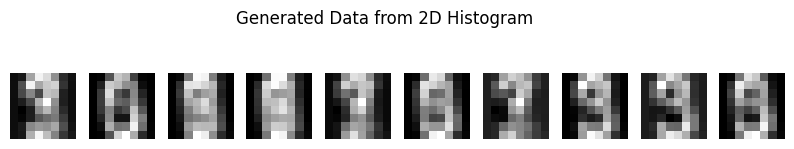

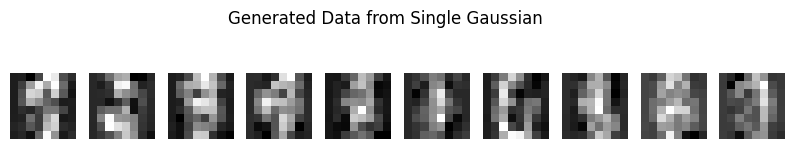

In [11]:
# Print MMD results
print(f"MMD for 2D Histogram Model: {mmd_histogram}")
print(f"MMD for Single Gaussian Model: {mmd_gaussian}")

# Function to plot generated samples as images
def plot_generated_digits(data, title="Generated Data"):
    n = data.shape[0]
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(data[i].reshape(8, 8), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Plot the generated samples in 8x8 grid format
plot_generated_digits(generated_data_64d[:10], "Generated Data from 2D Histogram")
plot_generated_digits(generated_data_gaussian[:10], "Generated Data from Single Gaussian")

